In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [3]:
cq_results = pd.read_csv("stat_by_day.csv",sep=';',decimal=',')
cq_results['Name'] = cq_results['DATE'].apply(lambda x: int(''.join(x.split('-'))))
cq_results.sort_values(by="Name",ascending=True, inplace=True)
cq_results.drop(columns=['DATE'],inplace=True)
# cq_results.head()

In [4]:
instance = pd.read_excel("instances.xlsx")
instance.head()

,Name,depot,client,order,driver,demand,cap,Instance,size,used
0,20201121,1,11,12,13,226.5,1,C_13_11_12_1,Small,1
1,20201010,1,5,8,13,267.0,1,C_13_5_8_1,Small,1
2,20201107,2,6,11,18,333.5,1,C_18_6_11_2,Small,1
3,20201031,2,4,7,15,375.0,1,C_15_4_7_2,Small,1
4,20201114,2,7,8,19,388.0,2,C_19_7_8_2,Small,1


In [291]:
def objective_function(x):
    return x.travelCost + 10000*x.undeliveredCost + \
        1000*x.firstDeliveryCost + \
            300*x.underWorkCost + 200*x.overTimeCost                       

In [323]:
my_results = pd.read_csv("results_LS.csv",sep=';')
my_results.sort_values(by="Name",ascending=True, inplace=True)
unsolved = list(dict.fromkeys(my_results[my_results['undeliveredCost']>0]['Name']))
my_results = my_results[my_results['undeliveredCost']<1]
print(len(unsolved),' ',  unsolved)
# my_results = my_results[my_results['Name'].isin([20201010,20201021,20201107,20201017,20201031,20201109,20201026,20201121,20201126])]

min_indices = my_results.groupby('Name')['travelCost'].idxmin()
result_df = my_results.loc[min_indices]

21   [20201001, 20201005, 20201008, 20201015, 20201017, 20201019, 20201022, 20201023, 20201027, 20201028, 20201030, 20201103, 20201104, 20201105, 20201106, 20201110, 20201116, 20201117, 20201119, 20201126, 20201127]


In [311]:
LS = pd.read_csv("results_LS.csv",sep=';')
LS.drop(['Date','Heure','Probleme','clientWaitingCost','MAX_OVERTIME',	'INTRA_ORDER_DELIVERY',
         'INTER_ORDER_DELIVERY','FIRST_DEL_MAX_ARRIVAL','Depot','maxfirstDelivery','driverUsed'],axis=1,inplace=True)
LS = LS[LS['undeliveredCost']<1]
LS = LS.loc[LS.groupby('Name')['travelCost'].idxmin()]
LS['Z_LS'] = LS.apply(lambda x: x.travelCost + x.undeliveredCost*1000+
                      x.firstDeliveryCost*500 + x.underWorkCost*50+ x.overTimeCost*100,axis=1)
# LS = LS[['Name','satisfiedCost', 'Z_LS']]
print(LS['satisfiedCost'].sum(), LS.shape[0])
GRASP = pd.read_csv("results_no_LS.csv",sep=';')
GRASP.drop(['Date','Heure','Probleme','clientWaitingCost','MAX_OVERTIME',	'INTRA_ORDER_DELIVERY',
         'INTER_ORDER_DELIVERY','FIRST_DEL_MAX_ARRIVAL','LOCAL_SEARCH','Depot','maxfirstDelivery','driverUsed'],axis=1,inplace=True)

GRASP = GRASP.loc[GRASP.groupby('Name')['travelCost'].idxmin()]
GRASP['Z'] = GRASP.apply(lambda x: x.travelCost + x.undeliveredCost*1000+
                      x.firstDeliveryCost*500 + x.underWorkCost*50+ x.overTimeCost*100,axis=1)
# GRASP = GRASP[['Name','satisfiedCost','Z']]


85827.0 36


In [320]:
df_compare = pd.merge(left=GRASP,right=LS,on='Name',how='right')
df_compare = pd.merge(left=df_compare,right=instance,how='inner',on='Name')

df_compare.head()
# df_compare = df_compare[['size','satisfiedCost_x']]
t1 = df_compare.groupby(by=['size']).agg({'demand':'sum','satisfiedCost_y':'sum',
                                          'runtime_y':'mean',
                                     'satisfiedCost_x':'sum',
                                          'runtime_x':'mean'
                                    #  'Z_LS':'mean'
                                     })
t1.sort_values(by=['demand'],inplace=True)
t1['serv_y'] = t1.apply(lambda x: 100*float(x['satisfiedCost_y'])/float(x['demand']),axis=1)
t1['serv_x'] = t1.apply(lambda x: 100*x['satisfiedCost_x']/float(x['demand']),axis=1)
t1['runtime_x'] = t1.runtime_x.apply(lambda x: (x/1000)/60)
t1['runtime_y'] = t1.runtime_y.apply(lambda x: (x/1000)/60)
print(t1.round(2))
df_compare = df_compare[df_compare['demand']==df_compare['satisfiedCost_y']]
df_compare.drop(['depot',	'client','order','driver'],axis=1,inplace=True)
t2 = df_compare.groupby(by=['size']).agg({
    # 'demand':'sum',
    'travelCost_y':'mean',
    'firstDeliveryCost_y':'sum',
                                     'underWorkCost_y':'mean','overTimeCost_y':'mean'
                                    # ,'Z':'mean'
                                     ,'travelCost_x':'mean'
                                    ,'firstDeliveryCost_x':'mean'
                                    ,'underWorkCost_x':'mean','overTimeCost_x':'mean'
                                    #  ,'Z_LS':'mean'
                                     })
t2.sort_values(by=['travelCost_y'],inplace=True)

numeric_columns = t2.select_dtypes(include=[float, int]).columns
t2[numeric_columns] = t2[numeric_columns].round(2)
t2.to_latex('LS_vs_noLS.tex')
print(t2.round(2))

         demand  satisfiedCost_y  runtime_y  satisfiedCost_x  runtime_x  \
size                                                                      
Small    3917.0           3917.0      50.34           3917.0      21.24   
Medium  32394.0          32394.0      50.60          32264.5      49.41   
Large   49516.0          49516.0      50.74          49127.0      50.20   

        serv_y  serv_x  
size                    
Small    100.0  100.00  
Medium   100.0   99.60  
Large    100.0   99.21  
        travelCost_y  firstDeliveryCost_y  underWorkCost_y  overTimeCost_y  \
size                                                                         
Small        1946.06                12.41           229.40          298.74   
Medium      15641.50              2856.37          2087.17         1769.29   
Large       22748.24              9070.66          1118.18         3650.25   

        travelCost_x  firstDeliveryCost_x  underWorkCost_x  overTimeCost_x  
size                           

/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_2624/2020821890.py:35: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  t2.to_latex('LS_vs_noLS.tex')


In [324]:
df = pd.merge(left=result_df,right=cq_results,how='inner',on='Name')
df = pd.merge(left=df,right=instance,how='inner',on='Name')

instance_stats = pd.DataFrame(df['size'].value_counts())
instance_stats.reset_index(inplace=True)
instance_stats['Load']=  instance_stats.apply ( lambda x: f"{df[df['size']==x['index']]['demand'].min()}-{df[df['size']==x['index']]['demand'].max()}",axis=1)
instance_stats['#Order']=  instance_stats.apply ( lambda x: f"{df[df['size']==x['index']]['order'].min()}-{df[df['size']==x['index']]['order'].max()}",axis=1)
instance_stats['#Client']=  instance_stats.apply ( lambda x: f"{df[df['size']==x['index']]['client'].min()}-{df[df['size']==x['index']]['client'].max()}",axis=1)
instance_stats['#Driver']=  instance_stats.apply ( lambda x: f"{df[df['size']==x['index']]['driver'].min()}-{df[df['size']==x['index']]['driver'].max()}",axis=1)
instance_stats['#Depot']=  instance_stats.apply ( lambda x: f"{df[df['size']==x['index']]['depot'].min()}-{df[df['size']==x['index']]['depot'].max()}",axis=1)
instance_stats.sort_values(by=['index'],inplace=True,ascending=False)
instance_stats.set_index(['index'],inplace=True)
instance_stats.to_latex('instance_stats.tex')
print((instance_stats))

        size           Load   #Order #Client  #Driver #Depot
index                                                       
Small      8    226.5-937.5     7-14    4-11    13-35    1-3
Medium    14  1160.5-2971.0    43-98   40-89   76-137    6-8
Large     14  3078.5-3953.5  107-136  92-127  129-150    8-8


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_2624/1692113513.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  instance_stats.to_latex('instance_stats.tex')


In [373]:
my_results = pd.read_csv("results_LS.csv",sep=';')
my_results.sort_values(by="Name",ascending=True, inplace=True)
unsolved = list(dict.fromkeys(my_results[my_results['undeliveredCost']>0]['Name']))
my_results = my_results[my_results['undeliveredCost']<1]

min_indices = my_results.groupby('Name')['travelCost'].idxmin()
result_df = my_results.loc[min_indices]
df = pd.merge(left=result_df,right=cq_results,how='inner',on='Name')
df = pd.merge(left=df,right=instance,how='inner',on='Name')

df['runtime'] = df['runtime'].apply(lambda x: (x/1000))
df['PUO'] = df.apply(lambda x: x.demand-x.satisfiedCost,axis=1)
df = df[['size','Instance','Name','depot',	'client','order','driver','satisfiedCost',
         'travelCost','PUO', 'firstDeliveryCost','maxfirstDelivery',
         'underWorkCost','overTimeCost','driverUsed','runtime']]
df.sort_values(by=["satisfiedCost"],ascending=True, inplace=True)
df.set_index(['size','Instance'],inplace=True)
numeric_columns = df.select_dtypes(include=[float, int]).columns
df[numeric_columns] = df[numeric_columns].round(2)
df.drop(['Name','depot','client','order','driver'],axis=1,inplace=True)
df.rename(columns={'satisfiedCost':'Load','travelCost':'TC','firstDeliveryCost':'FDD',
           'maxfirstDelivery':'max FDD','underWorkCost':'DUC','overTimeCost':'DOC'
           ,'runtime':'Time' },inplace=True)
df.to_latex('df.tex')
df.head()
with_shift_stat = df.groupby(by=['size']).mean()

/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_2624/4172454674.py:24: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex('df.tex')


In [371]:
my_results = pd.read_csv("results_no_shift.csv",sep=';')
my_results.sort_values(by="Name",ascending=True, inplace=True)
unsolved = list(dict.fromkeys(my_results[my_results['undeliveredCost']>0]['Name']))
my_results = my_results[my_results['undeliveredCost']<1]

min_indices = my_results.groupby('Name')['travelCost'].idxmin()
result_df = my_results.loc[min_indices]
df = pd.merge(left=result_df,right=cq_results,how='inner',on='Name')
df = pd.merge(left=df,right=instance,how='inner',on='Name')

df['runtime'] = df['runtime'].apply(lambda x: (x/1000))
df['PUO'] = df.apply(lambda x: x.demand-x.satisfiedCost,axis=1)
df = df[['size','Instance','Name','depot',	'client','order','driver','satisfiedCost','travelCost','PUO', 'firstDeliveryCost','maxfirstDelivery',
         'underWorkCost','overTimeCost','driverUsed','runtime']]
df.sort_values(by=["satisfiedCost"],ascending=True, inplace=True)
df.set_index(['size','Instance'],inplace=True)
numeric_columns = df.select_dtypes(include=[float, int]).columns
df[numeric_columns] = df[numeric_columns].round(2)
df.drop(['Name','depot','client','order','driver'],axis=1,inplace=True)
df.rename(columns={'satisfiedCost':'Load','travelCost':'TC','firstDeliveryCost':'FDD',
           'maxfirstDelivery':'max FDD','underWorkCost':'DUC','overTimeCost':'DOC'
           ,'runtime':'Time' },inplace=True)
df.to_latex('df_no_shift.tex')
df.head()
df.groupby(by=['size']).mean()
without_shift_stat = df.groupby(by=['size']).mean()


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_2624/1452104380.py:23: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex('df_no_shift.tex')


## Comparer les résultats avec et sans limitation de shift 

In [377]:
# with_shift_stat.reset_index(inplace=True)
# print(with_shift_stat)
# without_shift_stat.reset_index(inplace=True)
# print(type(without_shift_stat))
shift_stat = pd.merge(left=with_shift_stat,right=without_shift_stat,on='size')
shift_stat.set_index(['size'],inplace=True)
shift_stat.drop(['level_0','index_y','driverUsed_x','Time_x','DUC_x',	'DOC_x','PUO_x',
                 'driverUsed_y','DUC_y',	'DOC_y','Time_y','PUO_y'],axis=1,inplace=True)
numeric_columns = shift_stat.select_dtypes(include=[float, int]).columns
shift_stat[numeric_columns] = shift_stat[numeric_columns].round(2)
shift_stat.sort_values(by=['Load_x'],ascending=True,inplace=True)
shift_stat.to_latex('shift.tex')
shift_stat

/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_2624/1388255063.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  shift_stat.to_latex('shift.tex')


,index_x,Load_x,TC_x,FDD_x,max FDD_x,Load_y,TC_y,FDD_y,max FDD_y
size,,,,,,,,,
Small,2,489.62,1946.06,1.55,1.55,489.62,1832.90,0.00,0.00
Medium,1,2313.86,15641.50,204.03,31.59,2313.86,14607.66,74.76,16.56
Large,0,3536.86,22748.24,647.90,55.48,3536.86,22293.04,210.14,29.00


## Comparer plusieurs valeurs de lambda 1

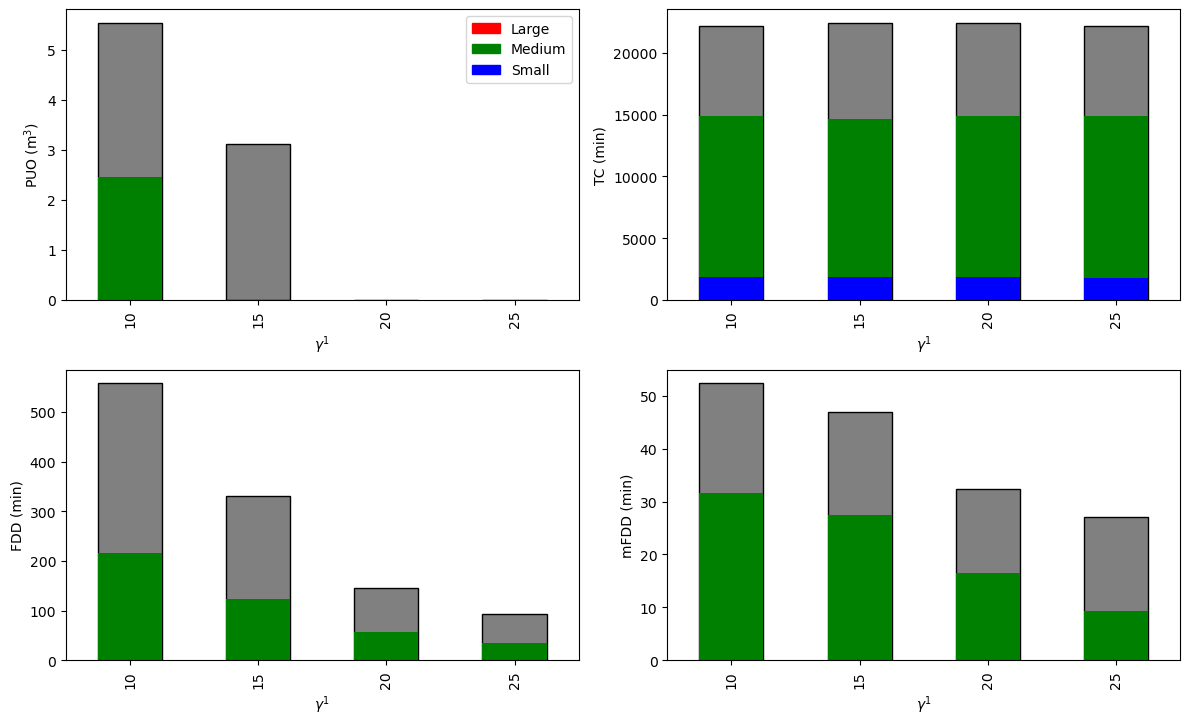

satisfiedCost  undeliveredCost    travelCost  \
size   INTRA_ORDER_DELIVERY                                                 
Large  10                      3531.321429         5.535714  22206.185714   
       15                      3533.750000         3.107143  22440.807143   
       20                      3536.857143         0.000000  22399.100000   
       25                      3536.857143         0.000000  22185.564286   
Medium 10                      2311.392857         2.464286  14922.646429   
       15                      2313.857143         0.000000  14641.090714   
       20                      2313.857143         0.000000  14935.137143   
       25                      2313.857143         0.000000  14873.314286   
Small  10                       489.625000         0.000000   1884.993750   
       15                       489.625000         0.000000   1861.581250   
       20                       489.625000         0.000000   1841.281250   
       25                       489.625000         0.000000   1807.656250   

                             firstDeliveryCost  maxfirstDelivery  driverUsed  
size   INTRA_ORDER_DELIVERY                                                   
Large  10                           557.395714         52.318571  140.071429  
       15                           330.325000         47.002143  140.214286  
       20                           145.977857         32.380000  140.428571  
       25                            92.358571         26.995714  139.785714  
Medium 10                           215.636429         31.640714  116.357143  
       15                           124.225714         27.397857  116.071429  
       20                            57.747857         16.489286  116.500000  
       25                            35.774286          9.392857  114.857143  
Small  10                             0.000000          0.000000   21.000000  
       15                             0.000000          0.000000   20.750000  
       20                             0.000000          0.000000   20.375000  
       25                             0.000000          0.000000   19.750000

In [517]:
my_results = pd.read_csv("results_lambda.csv",sep=';')
my_results = my_results[['Name','satisfiedCost','undeliveredCost',
                         	'travelCost','firstDeliveryCost','maxfirstDelivery','INTRA_ORDER_DELIVERY','driverUsed']]
df = pd.merge(left=my_results,right=instance,how='inner',on='Name')
numeric_columns = df.select_dtypes(include=[float, int]).columns
df[numeric_columns] = df[numeric_columns].round(2)
df.sort_values(['demand'],ascending=True,inplace=True)

df.groupby(by=['INTRA_ORDER_DELIVERY','Name']).agg({'satisfiedCost':'mean',
                                                            'undeliveredCost':'mean',
                                                            'travelCost':'mean',
                                                            'firstDeliveryCost':'mean',
                                                            'maxfirstDelivery':'mean',
                                                            'driverUsed':'mean'
                                                            })
t2 = df.groupby(by=['size','INTRA_ORDER_DELIVERY']).agg({'satisfiedCost':'mean',
                                                            'undeliveredCost':'mean',
                                                            'travelCost':'mean',
                                                            'firstDeliveryCost':'mean',
                                                            'maxfirstDelivery':'mean',
                                                            'driverUsed':'mean'
                                                            })

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
colonnes = ['undeliveredCost','travelCost','firstDeliveryCost','maxfirstDelivery']
colonne1 = [r'PUO (m$^3$)','TC (min)','FDD (min)','mFDD (min)']
id = 0

red_patch = mpatches.Patch(color='red', label='Large')
green_patch = mpatches.Patch(color='green', label='Medium')
blue_patch = mpatches.Patch(color='blue', label='Small')
# handles.append(red_patch)
custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
for ax,col in zip(axes.flatten(),colonnes):
    t2.xs(('Large')).plot(y =[f'{col}'],edgecolor='black',hatch ='/',  xlabel=None, legend=None, ax=ax,kind='bar',)
    t2.xs(('Medium')).plot(y =[f'{col}'],color='green',xlabel=None, legend=None, ax=ax ,kind='bar' )
    t2.xs(('Small')).plot(y =[f'{col}'],color='blue', legend=None,  ax=ax ,kind='bar' )
    ax.set_ylabel(f"{colonne1[id]}")
    ax.set_xlabel(f'$\gamma^1$')
    if id==0:
        ax.legend(handles=[red_patch,green_patch, blue_patch])        
    id = id + 1
handles, labels = ax.get_legend_handles_labels()

# plt.legend(custom_lines,['1','2','3'])
# fig.text(0.5, 0.05, f'$\lambda_1$', ha='center', fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("gamma1.pdf", format="pdf")
plt.show()
t2


## Comparer plusieurs runtime :5, 10, 30, 60 min

In [514]:
my_results = pd.read_csv("results_TIME_LIMIT3.csv",sep=';')
df = pd.merge(left=my_results,right=instance,how='inner',on='Name')
# my_results = my_results[my_results['undeliveredCost']<1]
df['served'] = df.apply(lambda x: 1 if x.undeliveredCost <1 else 0 ,axis=1)
df['Z'] = df.apply(lambda x: objective_function(x),axis=1)
df['completion'] = df.apply(lambda x: int(100*(x.satisfiedCost/x.demand)),axis=1)
df = df[['size','Name','served','satisfiedCost','undeliveredCost',
                         	'travelCost','firstDeliveryCost','maxfirstDelivery',
                            'underWorkCost','overTimeCost','driverUsed','TIME_LIMIT','runtime','Z','completion']]
df['TIME_LIMIT'] = df['TIME_LIMIT'].apply(lambda x: int((x/1000)/60))
df['runtime'] = df['runtime'].apply(lambda x: int((x/1000)/60))

numeric_columns = df.select_dtypes(include=[float, int]).columns
df[numeric_columns] = df[numeric_columns].round(2)
min_indices = df.groupby(by=['Name','TIME_LIMIT'])['satisfiedCost'].idxmax()
df1 = df.loc[min_indices]
t1 = df1.groupby(by=['size','TIME_LIMIT']).agg({ 'served':'sum','undeliveredCost':'mean','completion':'mean'})
numeric_columns = t1.select_dtypes(include=[float, int]).columns
t1[numeric_columns] = t1[numeric_columns].round(2)
df = df[df['served']==1]
runtime = t1.pivot_table( index=['size'], columns=['TIME_LIMIT'], values=['served','completion']).stack(level=0)
runtime.sort_values(by=['size'],ascending=False, inplace=True)
runtime.to_latex('runtime.tex')
runtime
# my_results['Name'].value_counts()

/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_87575/2154526682.py:23: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  runtime.to_latex('runtime.tex')


TIME_LIMIT             5       10     30     60
size                                           
Small  completion  100.00  100.00  100.0  100.0
       served        8.00    8.00    8.0    8.0
Medium completion   99.86   99.86  100.0  100.0
       served       13.00   13.00   14.0   14.0
Large  completion   99.79   99.93  100.0  100.0
       served       12.00   13.00   14.0   14.0

In [93]:

table = pd.pivot_table(my_results, values=['travelCost','distanceCost','runtime','satisfiedCost','driverUsed','firstDeliveryCost','underWorkCost','overTimeCost'], index=['Name'],
                           aggfunc={'satisfiedCost': np.max,'travelCost': np.min,'distanceCost': np.min,'driverUsed':np.max,
                                    'runtime': np.mean,'firstDeliveryCost':np.min,'underWorkCost':np.min,'overTimeCost':np.min})
table.reset_index(inplace=True)
df = pd.merge(left=table,right=cq_results,how='inner',on='Name')
df = pd.merge(left=df,right=instance,how='inner',on='Name')
# df = df[['Name','satisfiedCost','QUANTITY','distanceCost','d1','d2','DRIVER_NBR','driverUsed','runtime','firstDeliveryCost','underWorkCost','overTimeCost']]
df = df[['Name','satisfiedCost','QUANTITY','travelCost','distanceCost','d1','d2','DRIVER_NBR','driverUsed','runtime','firstDeliveryCost','underWorkCost','overTimeCost']]
df['runtime'] = df['runtime'].apply(lambda x: (x/1000)/60)
df['LOAD_GAP']= df.apply(lambda x: float(x.satisfiedCost) - float(x.QUANTITY),axis=1)
df['d1_GAP']= df.apply(lambda x: 100*(float(x.d1) - float(x.distanceCost))/float(x.distanceCost),axis=1)
df['d2_GAP']= df.apply(lambda x: 100*(float(x.d2) - float(x.distanceCost))/float(x.distanceCost),axis=1)
df.sort_values(by="QUANTITY",ascending=True, inplace=True)

# df = df[df['Name'].isin([20201010,20201021,20201107,20201017,20201031,20201109,20201026,20201121,20201126])]
print(df.shape[0])
df.set_index(['Name'],inplace=True)
numeric_columns = df.select_dtypes(include=[float, int]).columns

df[numeric_columns] = df[numeric_columns].round(2)
df = df[['satisfiedCost','driverUsed', 'travelCost','firstDeliveryCost','underWorkCost','overTimeCost','runtime']].to_latex('df.tex')
df

36


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_2624/1356761279.py:21: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df = df[['satisfiedCost','driverUsed', 'travelCost','firstDeliveryCost','underWorkCost','overTimeCost','runtime']].to_latex('df.tex')



table = pd.pivot_table(my_results, values=['travelCost','runtime','satisfiedCost','driverUsed'], index=['Name'],
                           aggfunc={'satisfiedCost': np.max,'travelCost': np.max,'driverUsed':np.max,
                                    'runtime': np.mean})
table.reset_index(inplace=True)
df = pd.merge(left=table,right=cq_results,how='right',on='Name')
df = df[['Name','satisfiedCost','QUANTITY','t1','t2','travelCost','DRIVER_NBR','driverUsed','runtime']]
df['LOAD_GAP']= df.apply(lambda x: float(x.satisfiedCost) - float(x.QUANTITY),axis=1)
df['t1_GAP']= df.apply(lambda x: 100*(float(x.t1) - float(x.travelCost))/float(x.travelCost),axis=1)
df['t2_GAP']= df.apply(lambda x: 100*(float(x.t2) - float(x.travelCost))/float(x.travelCost),axis=1)

df

my_results = pd.read_csv("results_lambda.csv",sep=';')
my_results = my_results[['Name','satisfiedCost','undeliveredCost',
                         	'travelCost','firstDeliveryCost','maxfirstDelivery','INTRA_ORDER_DELIVERY','driverUsed']]
df = pd.merge(left=my_results,right=instance,how='inner',on='Name')
numeric_columns = df.select_dtypes(include=[float, int]).columns
df[numeric_columns] = df[numeric_columns].round(2)
df.sort_values(['demand'],ascending=True,inplace=True)

df.groupby(by=['INTRA_ORDER_DELIVERY','Name']).agg({'satisfiedCost':'mean',
                                                            'undeliveredCost':'mean',
                                                            'travelCost':'mean',
                                                            'firstDeliveryCost':'mean',
                                                            'maxfirstDelivery':'mean',
                                                            'driverUsed':'mean'
                                                            })
t2 = df.groupby(by=['size','INTRA_ORDER_DELIVERY']).agg({'satisfiedCost':'mean',
                                                            'undeliveredCost':'mean',
                                                            'travelCost':'mean',
                                                            'firstDeliveryCost':'mean',
                                                            'maxfirstDelivery':'mean',
                                                            'driverUsed':'mean'
                                                            })#.to_csv('intra_order.csv',decimal=',',sep=';')
plt.figure(figsize=(10, 6))
plt.title("Satisfied Cost en fonction de size et intra_order")
plt.xlabel("size")
plt.ylabel("Satisfied Cost")
ax1 = plt.gca()
ax2 = ax1.twinx()
for size in list(set(t2.index.get_level_values('size'))):
    # ax1.plot(t2.xs((f"{size}"),level=0).index, t2.xs(f"{size}",level=0)['satisfiedCost'],marker='o', linestyle='-', label=f'size {size}')
    # plt.plot(t2.xs((f"{size}"),level=0).index, np.emath.logn(10,t2.xs(f"{size}",level=0)['travelCost']),marker='o', linestyle='-', label=f'travel {size}')
    # plt.plot(t2.xs((f"{size}"),level=0).index, np.log(t2.xs(f"{size}",level=0)['firstDeliveryCost']),marker='o', linestyle='-', label=f'firstDeliveryCost {size}')
    # plt.plot(t2.xs((f"{size}"),level=0).index, np.log(t2.xs(f"{size}",level=0)['maxfirstDelivery']), label=f'maxfirstDelivery {size}')
    # plt.plot(t2.xs((f"{size}"),level=0).index, np.log(t2.xs(f"{size}",level=0)['driverUsed']), label=f'driverUsed {size}')
    pass
# ax1.plot(t2.xs((f"Large"),level=0).index, t2.xs(f"Large",level=0)['satisfiedCost'],marker='o', linestyle='-', label=f'size Large')
# ax2.plot(t2.xs((f"Medium"),level=0).index, t2.xs(f"Medium",level=0)['satisfiedCost'],marker='x',color='red', linestyle='-', label=f'size Medium')
# ax2.plot(t2.xs((f"Small"),level=0).index, t2.xs(f"Small",level=0)['satisfiedCost'],marker='x',color='red', linestyle='-', label=f'size Small')


for val in list(set(t2.columns)):
    # ax1.plot(t2.xs((f"Large"),level=0).index, t2.xs(f"Large",level=0)[f'{val}'],marker='o', linestyle='-', label=f'size {val}')
    # break
    # plt.plot(t2.xs((f"{size}"),level=0).index, t2.xs(f"{size}",level=0)['travelCost'],marker='o', linestyle='-', label=f'size {val}')
    # plt.plot(t2.xs((f"Large"),level=0).index, np.emath.logn(10,t2.xs(f"Large",level=0)['travelCost']),marker='o', linestyle='-', label=f'travel {size}')
    # plt.plot(t2.xs((f"{size}"),level=0).index, np.log(t2.xs(f"{size}",level=0)['firstDeliveryCost']),marker='o', linestyle='-', label=f'firstDeliveryCost {size}')
    # plt.plot(t2.xs((f"{size}"),level=0).index, np.log(t2.xs(f"{size}",level=0)['maxfirstDelivery']), label=f'maxfirstDelivery {size}')
    # plt.plot(t2.xs((f"{size}"),level=0).index, np.log(t2.xs(f"{size}",level=0)['driverUsed']), label=f'driverUsed {size}')
    pass
# plt.plot(t2.xs(('Medium'),level=0).index, t2.xs(('Medium'),level=0)['satisfiedCost'], label=f' Medium')
# plt.plot(t2.xs(('Small'),level=0).index, t2.xs(('Small'),level=0)['satisfiedCost'], label=f' Small')
# t2.xs(('Large'),level=0).index
# t2['satisfiedCost']
# ax2 = ax1.twinx()
# ax2.plot(t2.xs((f"Large"),level=0).index, t2.xs(f"Large",level=0)[f'{t2.columns[1]}'],marker='x', linestyle='-', label=f'size {t2.columns[1]}')
# ax2.plot(t2.xs((f"Large"),level=0).index, t2.xs(f"Large",level=0)[f'{t2.columns[2]}'],marker='x', linestyle='-', label=f'size {t2.columns[2]}')


# t2.loc['Large'].plot(y='satisfiedCost')
# t2.loc['Small'].plot(y='satisfiedCost')
df.reset_index(inplace=True)
df.set_index(['size','INTRA_ORDER_DELIVERY','Instance'],inplace=True)
for col in ['satisfiedCost','undeliveredCost','travelCost','firstDeliveryCost','maxfirstDelivery']:
    df.sort_values([f'{col}'],ascending=True,inplace=True)
    for size in ['Large']:
        intra =  [15,20,25]
        markers=['x','o','+','s']
        for i,val in enumerate(intra):
            t1_10 = df.xs((f'{size}',val))
            # ax1.plot( t1_10.index, t1_10[f'{col}'],marker=f'{markers[i]}', linestyle='--', label=f'size {col}_{val}_{intra}')
            # t1_10.plot(kind='bar',ax=ax1,y=f'{col}')
            
    break
# plt.xticks(t1.index)
t2.xs(('Large')).plot(y =['undeliveredCost'],color='red',  ax=ax1 ,kind='bar' )
t2.xs(('Medium')).plot(y =['undeliveredCost'],color='blue', ax=ax1 ,kind='bar' )
t2.xs(('Small')).plot(y =['undeliveredCost'],color='yellow', ax=ax1 ,kind='bar' )
# plt.legend()
# plt.ylim(-1, np.log10(max(t2['satisfiedCost'])))
plt.show()
# df.plot(kind='bar', ax=plt.gca(), width=0.8)
# instance
# t2.xs(f"Large",level=0)['travelCost']
# t2.xs(('Large'))['travelCost']
t2